In [2]:
import pandas as pd
import numpy as np
import pickle
import itertools
import matplotlib.pyplot as plt
import statsmodels
import seaborn as sns
sns.set()

# Preliminary Preparation

### Deal with missing (?) values

In [8]:
#Mark missing fields in records as missing, rather than with a ? symbol
flattened_df = pd.read_csv('flattened_data.csv')
flattened_df = flattened_df.replace('?', np.nan)

### Deal with redundant columns

The marital status, sex, and relationship columns should not all be included. If we know the marital status and sex  for a record, we almost certainly know the "relationship" value. This column, therefore, is not adding much information to our model. While including it may not hurt our model's performance (unless we measure performance with a penalty that is adjusted for the number of features we are using), the multicollinearity between this field and the other two mentioned would make it difficult to interpret any regression coefficients we output for these three fields. Therefore, it is likely best to drop the relationship column altogether.

In [635]:
full_data_df = full_data_df.drop(columns='relationship')

### Deal with categorical fields
With so many different responses (16) in the education category, it may be hard to tease out what any one education level's impact on the outcome variable is. While this may not be a hindrance to our model's predictive power, it will be a hindrance to our model's explanatory power, particularly when attempting to interpret regression coefficients for the logistic regression model.  

##### Categorize education responses into broader buckets

In [636]:
#Create dictionary of each education category and list of responses that fall into category.
recordval_to_education_cat = {}
education_cats = {'no_ms': ['Preschool','1st-4th'], 'no_hs':['5th-6th', '7th-8th'], 
                  'some_hs':['9th', '10th', '11th', '12th'], 'hs_grad':['HS-grad'], 
                  'assoc_prof':['Assoc-acdm', 'Assos-voc', 'Prof-school'], 
                  'some_college':['Some-college'], 'college_grad':['Bachelors'], 
                  'masters':['Masters'], 'doctorate':['Doctorate']}
#Use to create dictionary of each response and its category that will be used to populate dataframe.
for broad_category, records_value_list in education_cats.items():
    for value in records_value_list:
        recordval_to_education_cat[value] = broad_category
        
#Replace each response to education question in master dataframe with .
broad_educ_df = full_data_df.replace(recordval_to_education_cat)

##### Categorize countries of origin by wealth

In [637]:
#Check for value names that might be problematic to match with World Bank 1996 GDP Dataset.
broad_educ_df['country'].value_counts()

United-States                 43832
Mexico                          951
Philippines                     295
Germany                         206
Puerto-Rico                     184
Canada                          182
El-Salvador                     155
India                           151
Cuba                            138
England                         127
China                           122
South                           115
Jamaica                         106
Italy                           105
Dominican-Republic              103
Japan                            92
Guatemala                        88
Poland                           87
Vietnam                          86
Columbia                         85
Haiti                            75
Portugal                         67
Taiwan                           65
Iran                             59
Greece                           49
Nicaragua                        49
Peru                             46
Ecuador                     

In [638]:
wbank_96 = pd.read_csv('wbank_96_gdp_per_capita.csv', header=0, usecols=['Country Name', '1996','2002'])
wbank_96.loc[wbank_96['1996'].isnull(),'1996'] = wbank_96['2002']

#Dashes,Outlying US, Holand-Netherlands, and "Columbia" appear problematic. Small number of issues--hard code.
def prep_for_match(country):
    country = str(country)
    replacement_dict = {"Columbia": "Colombia",
                       "Scotland": "United Kingdom",
                       "England": "United Kingdom",
                       "Holand-Netherlands":"Netherlands",
                       "Outlying-US(Guam-USVI-etc)":"Guam",
                       "Trinadad&Tobago":"Trinidad and Tobago",
                       "Hong":"Hong Kong SAR, China",
                       "Iran": "Iran, Islamic Rep.",
                       "Taiwan":"China",
                       "Yugoslavia":"Serbia",
                       "Laos":"Lao PDR"}
    if country in replacement_dict.keys():
        country = replacement_dict[country]
    country = country.replace('-', ' ')
    if country != np.nan and country not in set(wbank_96['Country Name']):
        if country == "South":
            country = np.nan
        else:
            print(f'ERROR {country} not in World Bank dataset. Replacing with nan')
        country = np.nan
    return country


In [639]:
prep_test_df = broad_educ_df

In [640]:
for value in set(prep_test_df['country']):
    if value not in (set(wbank_96['Country Name'])):
        print(value)

nan
Iran
Outlying-US(Guam-USVI-etc)
Dominican-Republic
El-Salvador
Scotland
Trinadad&Tobago
Hong
England
South
Holand-Netherlands
Laos
Taiwan
Yugoslavia
Columbia
United-States
Puerto-Rico


In [641]:
for country in set(prep_test_df['country']):
    country = prep_for_match(country)
    c_list.append(country)
    if country not in (set(wbank_96['Country Name'])):
        print(country)

ERROR nan not in World Bank dataset. Replacing with nan
nan
nan


In [642]:
income_level_df = broad_educ_df
income_level_df['country_income'] = None

In [643]:
income_level_df['country']

id
1        United-States
2        United-States
3        United-States
4        United-States
5                 Cuba
             ...      
48838    United-States
48839    United-States
48840    United-States
48841    United-States
48842    United-States
Name: country, Length: 48842, dtype: object

In [644]:
income_cutoffs = {'Low': wbank_96[wbank_96['Country Name']=='Low income']['1996'].values[0],
                  'Lower Middle Income': wbank_96[wbank_96['Country Name']=='Lower middle income']['1996'].values[0],
                  'Middle Income': wbank_96[wbank_96['Country Name']=='Middle income']['1996'].values[0],
                  'Upper Middle Income': wbank_96[wbank_96['Country Name']=='Upper middle income']['1996'].values[0]}

def assign_income_levels(country):
    income_level = None
    if country == "United States":
        income_level = "US"
    elif country == np.nan:
        income_level = np.nan
    else:
        for income_bracket, lower_cuttoff in income_cutoffs.items():
                if country in set(wbank_96['Country Name']):
                    if wbank_96[wbank_96['Country Name']== country]['1996'].values[0] < income_cutoffs[income_bracket]:
                        income_level = income_bracket
                        break
                    else:
                        if income_bracket == 'Upper Middle Income':
                            income_level = 'High Income'
                            continue
    return income_level
            
income_level_df['country'] = income_level_df['country'].apply(prep_for_match)

ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing w

ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing w

ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing w

ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing w

ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing w

ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing with nan
ERROR nan not in World Bank dataset. Replacing w

In [645]:
income_level_df['country'].value_counts()


income_level_df['country_income'] = income_level_df['country'].apply(assign_income_levels)
income_level_df = income_level_df.drop(columns=['country'])

# Data Exploration

In [646]:
categorical_columns = ['educ_level', 'marital_status', 'occupation_name', 'race', 'sex', 'workclass', 'country_income']
numerical_columns =[]
for column in income_level_df.columns:
    if column not in categorical_columns:
         numerical_columns.append(str(column))


In [647]:
income_level_df.describe(include=np.object)

,educ_level,marital_status,occupation_name,race,sex,workclass,country_income
count,48842,48842,46033,48842,48842,46043,47870
unique,10,7,14,5,2,8,5
top,hs_grad,Married-civ-spouse,Prof-specialty,White,Male,Private,US
freq,15784,22379,6172,41762,32650,33906,43832


In [648]:
income_level_df.describe(include=np.number)

,age,capital_gain,capital_loss,hours_week,over_50k
count,48842.000000,48842.000000,48842.000000,48842.000000,48842.000000
mean,38.643585,1079.067626,87.502314,40.422382,0.239282
std,13.710510,7452.019058,403.004552,12.391444,0.426649
min,17.000000,0.000000,0.000000,1.000000,0.000000
25%,28.000000,0.000000,0.000000,40.000000,0.000000
50%,37.000000,0.000000,0.000000,40.000000,0.000000
75%,48.000000,0.000000,0.000000,45.000000,0.000000
max,90.000000,99999.000000,4356.000000,99.000000,1.000000


In [649]:
gain_counts = income_level_df['capital_gain'].value_counts().rename_axis('unique_values').reset_index(name='counts')
gain_counts.sort_values(by='unique_values')

,unique_values,counts
0,0,44807
72,114,8
92,401,5
16,594,52
63,914,10
...,...,...
55,25236,14
14,27828,58
84,34095,6
110,41310,3


In [650]:
#With 244 999999 values and next closest value being 41,310 (freq=3), it appears 99999 may be placeholder for
#unknown, or something similar. Will drop 99999 values, as we are treating this as a continuous variable.
income_level_df['capital_gain'] = income_level_df['capital_gain'].replace({99999:np.nan})

In [651]:
#Does not appear to be a similar issue with capital loss column. Perhaps those with unknown gain/loss are coded as
#99999 in the capital gain column.
gain_counts = income_level_df['capital_gain'].value_counts().rename_axis('unique_values').reset_index(name='counts')
gain_counts.sort_values(by='unique_values')

,unique_values,counts
0,0.0,44807
74,114.0,8
95,401.0,5
15,594.0,52
66,914.0,10
...,...,...
85,25124.0,6
53,25236.0,14
13,27828.0,58
84,34095.0,6


In [652]:
#Unclear how capital gain and loss relate; Should be on either side of zero/measuring the same thing. Check if true.
print(len(income_level_df[(income_level_df['capital_gain'] > 0) & (income_level_df['capital_loss'] > 0)]))

0


In [653]:
#Capital loss appears to simply be a way of expressing negative capital gains; summarize both in capital gains column
income_level_df['capital_gain'] = income_level_df['capital_gain'] - income_level_df['capital_loss']
income_level_df = income_level_df.drop(columns = 'capital_loss')
numerical_columns.remove('capital_loss')

In [654]:
income_level_df

,age,educ_level,marital_status,occupation_name,race,sex,workclass,capital_gain,hours_week,over_50k,country_income
id,,,,,,,,,,,
1,39,college_grad,Never-married,Adm-clerical,White,Male,State-gov,2174.0,40,0,US
2,50,college_grad,Married-civ-spouse,Exec-managerial,White,Male,Self-emp-not-inc,0.0,13,0,US
3,38,hs_grad,Divorced,Handlers-cleaners,White,Male,Private,0.0,40,0,US
4,53,some_hs,Married-civ-spouse,Handlers-cleaners,Black,Male,Private,0.0,40,0,US
5,28,college_grad,Married-civ-spouse,Prof-specialty,Black,Female,Private,0.0,40,0,High Income
...,...,...,...,...,...,...,...,...,...,...,...
48838,39,college_grad,Divorced,Prof-specialty,White,Female,Private,0.0,36,0,US
48839,64,hs_grad,Widowed,NaN,Black,Male,NaN,0.0,40,0,US
48840,38,college_grad,Married-civ-spouse,Prof-specialty,White,Male,Private,0.0,50,0,US


In [655]:
# 8 Percent of all rows have a null value.
percentage_null = ((income_level_df.drop(columns='over_50k').isnull().any(axis=1).value_counts()) / len(income_level_df)) *100
percentage_null

False    91.912698
True      8.087302
dtype: float64

In [656]:
# But no rows have a null outcome variable (over 50k)
percentage_outcome_null = ((income_level_df.isnull().over_50k.value_counts()) / len(income_level_df)) *100
percentage_outcome_null

False    100.0
Name: over_50k, dtype: float64

In [657]:
#With almost 10% of the data containing a null column, should impute values rather than drop all observations.
#See how many rows have multiple missing values. 11 features
for number_missing in list(range(0,11)):
    percent_dropped = ((len(income_level_df) - len(income_level_df.dropna(thresh=11-number_missing, axis=0)))/len(income_level_df))*100
    print(f'Constraint: at most {number_missing} missing \t Percentage dropped: {percent_dropped}')


Constraint: at most 0 missing 	 Percentage dropped: 8.087301912288604
Constraint: at most 1 missing 	 Percentage dropped: 5.751197739650301
Constraint: at most 2 missing 	 Percentage dropped: 0.13103476516113183
Constraint: at most 3 missing 	 Percentage dropped: 0.002047418205642685
Constraint: at most 4 missing 	 Percentage dropped: 0.0
Constraint: at most 5 missing 	 Percentage dropped: 0.0
Constraint: at most 6 missing 	 Percentage dropped: 0.0
Constraint: at most 7 missing 	 Percentage dropped: 0.0
Constraint: at most 8 missing 	 Percentage dropped: 0.0
Constraint: at most 9 missing 	 Percentage dropped: 0.0
Constraint: at most 10 missing 	 Percentage dropped: 0.0


In [658]:
#If we drop only rows with > 2 values missing, only drop 0.13% of our dataset. Likely can afford this loss in power.
income_level_df = income_level_df.dropna(thresh=9, axis=0)

In [666]:
dropped_df = income_level_df

# Split into train and test set

In [667]:
#Fill in missing values in rows with 2 or less missing values. 
#For numerical values, fill in with mean. For categorical, fill in with the mode.
dropped_df[numerical_columns] = income_level_df[numerical_columns].fillna(dropped_df.median().iloc[0])
dropped_df[categorical_columns] = income_level_df[categorical_columns].fillna(dropped_df.mode().iloc[0])



In [668]:
#Break all categorical variables into dummy variables; Drop the first category for each.
prepped_data_df = pd.get_dummies(income_level_df, prefix=categorical_columns, columns=categorical_columns, drop_first=True)

### Splitting the data (using the broad education categories dataset for now)

In [347]:
#Create dataframe of input values, dataframe of output values
model_X = prepped_data_df.drop('over_50k', axis=1)
model_y = prepped_data_df['over_50k']

In [348]:
#Split dataframe into train, val, test sets in 60-20-20 ratio. 
#Split 60 to 40 into training and test/val, 
X_train, X_test_val, y_train, y_test_val = train_test_split(
    model_X, model_y, test_size=0.4, random_state=48)

#Split test/val 5050 into training and validation 
X_val, X_test, y_val, y_test = train_test_split(
    X_test_val, y_test_val, test_size=0.5, random_state=48)


# Logistic Regression Model

In [415]:
class metric_output():
    def __init__(self, model_name, model):
        self.model_name = model_name

        y_train_pred = model.predict(X_train)
        y_train_pred_prob = model.predict_proba(X_train)

        y_val_pred = model.predict(X_val)
        y_val_pred_prob = model.predict_proba(X_val)

        self.y_train_pred_prob = y_train_pred_prob[:,1]
        self.y_val_pred_prob = y_val_pred_prob[:,1]
        
        self.train_auroc = roc_auc_score(y_train, self.y_train_pred_prob)
        self.val_auroc = roc_auc_score(y_val, self.y_val_pred_prob)
        
        self.train_precision = precision_score(y_train, y_train_pred)
        self.val_precision = precision_score(y_val, y_val_pred)
        
        self.train_recall = recall_score(y_train, y_train_pred)
        self.val_recall = recall_score(y_val, y_val_pred)

        self.train_f1 = f1_score(y_train, y_train_pred)
        self.val_f1 = f1_score(y_val, y_val_pred)

        self.train_accuracy = accuracy_score(y_train, y_train_pred)
        self.val_accuracy = accuracy_score(y_val, y_val_pred)
        
        
        self.metrics = ['Accuracy', 'AUROC', 'Precision', 'Recall', 'F1 Score']
        self.train_outputs = [self.train_accuracy, self.train_auroc, self.train_precision, 
                              self.train_recall, self.train_f1]
        self.val_outputs = [self.val_accuracy, self.val_auroc, self.val_precision, 
                            self.val_recall, self.val_f1]
        metrics_dict = {'Metric': self.metrics, 'Train Set': self.train_outputs, 
                        'Validation Set': self.val_outputs}    
        self.metrics_df = pd.DataFrame(metrics_dict).set_index('Metric')
        
        
    def plot_auroc(self):
        def draw_curve(y_real,y_pred_prob, name, color):
            fpr, tpr, threshold = roc_curve(y_real, y_pred_prob)
            roc_auc = auc(fpr, tpr)
            line_out = plt.plot(fpr, tpr, color, label = f'{name} AUC = {roc_auc}')
            return line_out
        
        draw_curve(y_train,self.y_train_pred_prob, 'Train', 'r')
        draw_curve(y_val,self.y_val_pred_prob, 'Val', 'b')
        plt.title('Receiver Operating Characteristic')
        plt.legend(loc = 'lower right')
        plt.plot([0, 1], [0, 1],'r--')
        plt.xlim([0, 1])
        plt.ylim([0, 1])
        plt.ylabel('True Positive Rate')
        plt.xlabel('False Positive Rate')
        plt.show()



        
    def add_to_master_metrics(self, master_metric_outs):
        master_metric_df = master_metric_outs[0]
        master_metric_list = master_metric_outs[1]

        metrics_dict_for_master = {'Model': [self.model_name,'','','',''], 'Train Set': self.train_outputs, 
                                   'Validation Set': self.val_outputs}
        
        metrics_df_for_master = pd.DataFrame(metrics_dict_for_master).set_index('Model')

        master_metric_df = master_metric_df.append(metrics_df_for_master)
        master_metric_list.append(self)
        
        master_metric_outs = [master_metric_df, master_metric_list]
        return master_metric_outs
        

    

In [416]:
master_out_df = pd.DataFrame()
master_out_list = []
master_outputs = [master_out_df, master_out_list]

logreg = LogisticRegression()
logreg.fit(X_train, y_train)

log1out = metric_output('logreg1', logreg)
master_outputs = log1out.add_to_master_metrics(master_outputs)

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


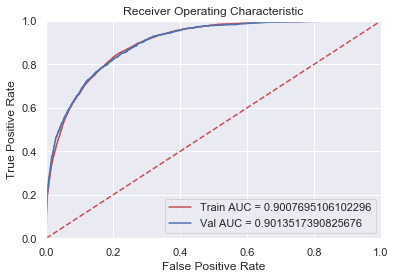

In [417]:
log1out.plot_auroc()

# Random Forest/Decision Tree Model

In [266]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier(random_state=456)
tree.fit(X_train, y_train)
y_train_pred = tree.predict(X_train)
tree1out = metric_output('tree1',tree)

In [267]:
tree1out.metrics_df

,Train Set,Validation Set
Metric,,
Accuracy,0.976489,0.818796
AUROC,0.998282,0.765005
Precision,0.980180,0.644038
Recall,0.920006,0.597101
F1 Score,0.949140,0.619682


In [298]:
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(criterion="gini", n_estimators = 100)
model.fit(X_train, y_train)
tree2out = metric_output('tree2', model)
tree2out.metrics_df

,Train Set,Validation Set
Metric,,
Accuracy,0.976489,0.843366
AUROC,0.997107,0.889490
Precision,0.958509,0.720919
Recall,0.942187,0.597930
F1 Score,0.950278,0.653689


In [314]:
n_estimators = list(range(0, 200))
max_depth = list(range(20,150))
max_depth.append(None)
bootstrap = ['True', 'False']
max_features = list(range(1,len(X_train.columns)))

rand_params_dict = {'n_estimators':n_estimators, 
                 'max_depth':max_depth, 
                 'bootstrap':bootstrap, 
                 'max_features':max_features}

In [327]:
from sklearn.model_selection import RandomizedSearchCV

rfor = RandomForestClassifier()
rfor_rand = RandomizedSearchCV(estimator = rfor, scoring='f1', param_distributions = rand_params_dict, 
                               n_iter = 100, cv = 2, random_state=43, n_jobs=-1)
rfor_rand.fit(X_train, y_train)


RandomizedSearchCV(cv=2, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [328]:
rfor_rand.best_params_

{'n_estimators': 165,
 'max_features': 44,
 'max_depth': 20,
 'bootstrap': 'False'}

In [344]:
#Best parameters: {'n_estimators': 165, 'max_features': 44,'max_depth': 20,'bootstrap': 'False'}

best_rand_rf = rfor_rand.best_estimator_
best_rand_output = metric_output('best random model', best_rand_rf)
best_rand_output.metrics_df

,Train Set,Validation Set
Metric,,
Accuracy,0.929364,0.860156
AUROC,0.981754,0.911501
Precision,0.923236,0.793181
Recall,0.767602,0.587578
F1 Score,0.838256,0.675071


In [ ]:
pickle.dump(best_rand_rf, open( "best_rand_rf.p", "wb" ))

In [339]:
from sklearn.model_selection import GridSearchCV

n_estimators = [145, 165, 185]
max_depth = [None, 10, 20, 30]
bootstrap = ['False']
max_features = [35,45,55]


grid_params_dict = {'n_estimators':n_estimators, 
                 'max_depth':max_depth, 
                 'bootstrap':bootstrap, 
                 'max_features':max_features}

rfor_grid = GridSearchCV(estimator = rfor, scoring='f1', param_grid = grid_params_dict, 
                                cv = 3, n_jobs=-1)
rfor_grid.fit(X_train, y_train)


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [342]:
best_grid_rf = rfor_grid.best_estimator_
best_grid_output = metric_output('best random model', best_grid_rf)
best_grid_output.metrics_df

pickle.dump(best_grid_rf, open( "best_grid_rf.p", "wb" ))

In [345]:
rfor_grid.best_params_

{'bootstrap': 'False',
 'max_depth': 20,
 'max_features': 35,
 'n_estimators': 185}

In [343]:
best_grid_output.metrics_df

,Train Set,Validation Set
Metric,,
Accuracy,0.926429,0.861486
AUROC,0.980444,0.911754
Precision,0.918572,0.796317
Recall,0.758729,0.590890
F1 Score,0.831034,0.678393


In [22]:
n_estimators = [185, 195, 205]
max_depth = [20]
bootstrap = ['False']
max_features = [15,25,35]


grid2_params_dict = {'n_estimators':n_estimators, 
                 'max_depth':max_depth, 
                 'bootstrap':bootstrap, 
                 'max_features':max_features}

rfor_grid2 = GridSearchCV(estimator = rfor, scoring='f1', param_grid = grid2_params_dict, 
                                cv = 3, n_jobs=-1)
rfor_grid2.fit(X_train, y_train)

GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             iid

In [23]:
rfor = RandomForestClassifier()
best_grid2_rf = rfor_grid2.best_estimator_
best_grid2_output = metric_output('best random model', best_grid2_rf)
best_grid2_output.metrics_df

,Train Set,Validation Set
Metric,,
Accuracy,0.921583,0.861384
AUROC,0.978456,0.914098
Precision,0.911692,0.798201
Recall,0.743131,0.587992
F1 Score,0.818827,0.677158


In [24]:
rfor_grid2.best_params_

{'bootstrap': 'False',
 'max_depth': 20,
 'max_features': 25,
 'n_estimators': 195}